In [2]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import re
import os

train = bz2.BZ2File('train.ft.txt.bz2')
test = bz2.BZ2File('test.ft.txt.bz2')

In [3]:
labels = []
texts = []

line = train.readline().decode('utf-8')
labels.append(int(line[9]) - 1)
texts.append(line[10:].strip())
texts

['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^']

In [4]:
def preprocess(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        line = line.decode('utf-8')
        labels.append(int(line[9]) - 1)
        texts.append(line[10:].strip())
    return np.array(labels), texts

train_labels, train_texts = preprocess('train.ft.txt.bz2')
test_labels, test_texts = preprocess('test.ft.txt.bz2')

In [5]:
re.sub('^[a-zA-Z]',' ',str(train_texts[0]))

' tuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [6]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
def process(review):
    review = re.sub("[^a-zA-Z]",' ',review)
    review = review.lower()
    review = review.split()
    swords = set(stopwords.words("english"))  # conversion into set for fast searching
    review = [w for w in review if w not in swords]               
    return(" ".join(review))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehmu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df=pd.DataFrame(train_texts)
df['sentiment']=train_labels
df.columns=['review','sentiment']
df

,review,sentiment
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1
...,...,...
3599995,Don't do it!!: The high chair looks great when...,0
3599996,"Looks nice, low functionality: I have used thi...",0
3599997,"compact, but hard to clean: We have a small ho...",0
3599998,what is it saying?: not sure what this book is...,0


In [8]:
df=df[:60000]

In [9]:
train_data = []
for i in range(len(df["review"])):        
    if (i+1)%2500 == 0:        
        print("Result =", i+1)
    train_data.append(process(df["review"][i]))

Result = 2500
Result = 5000
Result = 7500
Result = 10000
Result = 12500
Result = 15000
Result = 17500
Result = 20000
Result = 22500
Result = 25000
Result = 27500
Result = 30000
Result = 32500
Result = 35000
Result = 37500
Result = 40000
Result = 42500
Result = 45000
Result = 47500
Result = 50000
Result = 52500
Result = 55000
Result = 57500
Result = 60000


In [10]:
from sklearn.model_selection import train_test_split
X = train_data
y = np.array(df["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y ,test_size = 0.2, shuffle = True,random_state=42)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 10000)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

X_train = X_train.toarray()
X_test = X_test.toarray()

In [12]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

In [13]:
classifiers = {
    "LR": LogisticRegression(max_iter=1000), 
    "MLP": MLPClassifier(max_iter=1000),
    "LGBM": LGBMClassifier()
}

results = pd.DataFrame(columns=["Classifier", "Avg_Accuracy", "Avg_F1_Score"])
for name, clf in classifiers.items():
    print(name)
    model = clf
    cv_results = cross_validate(
        model, X_train, y_train, cv=5,
        scoring=(['accuracy', 'f1'])
    )

    results = results.append({
        "Classifier": name,
        "Avg_Accuracy": cv_results['test_accuracy'].mean(),
        "Avg_F1_Score": cv_results['test_f1'].mean()
    }, ignore_index=True)
    
results["Avg_Overall"] = (results["Avg_Accuracy"] + results["Avg_F1_Score"]) / 2
results = results.sort_values("Avg_Overall", ascending=False)
results

LR


C:\Users\mehmu\AppData\Local\Temp\ipykernel_15640\1895371698.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


MLP


C:\Users\mehmu\AppData\Local\Temp\ipykernel_15640\1895371698.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


LGBM


C:\Users\mehmu\AppData\Local\Temp\ipykernel_15640\1895371698.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


,Classifier,Avg_Accuracy,Avg_F1_Score,Avg_Overall
0,LR,0.865125,0.869712,0.867419
2,LGBM,0.853583,0.859802,0.856693
1,MLP,0.854042,0.858722,0.856382


In [13]:
clf=LogisticRegression(max_iter=1000)
clf.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

Train Accuracy: 0.8668333333333333
Train F1-Score: 0.8712743676494281


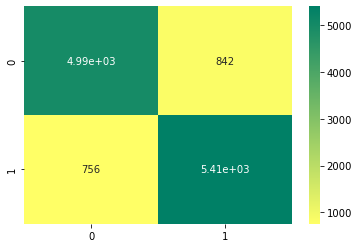

In [14]:
import seaborn as sbn
import matplotlib.pyplot as plt
y_pred = clf.predict(X_test)
print(f"Train Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Train F1-Score: {f1_score(y_test, y_pred)}")
sbn.heatmap(confusion_matrix(y_test, y_pred), fmt='.3g', annot=True, cmap='summer_r')
plt.show()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5836
           1       0.87      0.88      0.87      6164

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000

